# Quantifiers

The quantifiers are parameters calculated for each simulation that allows us to evaluate the characteristics of the colonie. The main characteristic are the four-cell organisation and the elongation of the colony.

This notebook serves to calculate the quantifiers for a serie of simulation files. It also support the experimental converted files but the functions used are different.

The chosen quantifiers are :
- the aspect ratio $\alpha_r$.
- the density $\delta$.
- $s$ the mean of the difference between the distance the rest length of two disks.
- the bending energy $E_t$.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from PIL import Image
from skimage import measure
from skimage.io import imread
from skimage.morphology import convex_hull_image
from skimage import data, img_as_float
from skimage.util import invert
from scipy.ndimage import binary_fill_holes
from skimage.measure import EllipseModel
from numpy.linalg import norm
import random
import os
import glob
import sys
import time as tm

# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1,r'../')
import plot_model as pm
import plot_model_exp as pmx

## Data loading and cleaning

We used the function from **data.ipynb**. We also load a testing dataframe.

In [2]:
# testing files
file = "simuc1"
def convert(L):
    T = L.split(" ")
    T.pop()
    return list(np.array(T,dtype=float))

DF = pd.read_csv("./simuc_data/" + file +".txt",sep="\t")

DF["X"]=DF["X"].apply(convert)
DF["time"] = DF["time"].apply(int)

df = DF.loc[DF["time"]==DF["time"].max()]
df = df.reset_index()


## 1. Calculating the aspect ratio

Here is the function used to calculate the aspect ratio of a colony from a dataframe. it comes with an example and plots of the convexhull.

The aspect ratio refers to the elongation of the shape of the colony.
To calculate $\alpha_r$, we need to calculate the convex hull of the points of the colony and fit an ellipse on it. $\alpha_r$ is then defined as the ratio $\frac{l}{L}$ with $l$ the semi-minor axis and $L$ the semi-major axis.
<br>The aspect ratio equal 1 if the colony form a perfect circle

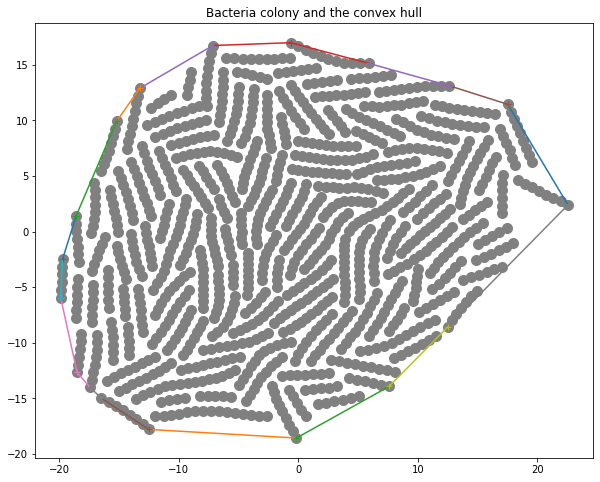

In [3]:
def convex_hull(df):
    """Returns two lists containing the points of the convex hull"""

    # Merge all the X datas
    X = []
    dfX = df["X"]
    for i in range(dfX.shape[0]):
        X = X + dfX[i]

    # Separates x and y
    x=X[0::2]
    y=X[1::2]

    # Converting the points to a compatible format for the Convexhull class
    points = np.array([x,y])
    points = np.transpose(points)

    x1 =[]
    y1 =[]
    
    if(df.shape[0]>1):
        # Calculating the hull
        hull = ConvexHull(points)

        # Calculating the vertices of the hull
        for i in hull.vertices:
            x1.append(x[i])
            y1.append(y[i])
        return x1,y1
    else:
        return [x[0],x[-1]],[y[0],y[-1]]

### Convex hull calculation for the maximum time
# Merge all the X datas
X = []
dfX = df["X"]
for i in range(dfX.shape[0]):
    X = X + dfX[i]

# Separates x and y
x=X[0::2]
y=X[1::2]

# Converting the points to a compatible format for the Convexhull class
points = np.array([x,y])
points = np.transpose(points)

x1 =[]
y1 =[]
if df.shape[0]!=1:
    # Calculating the hull
    hull = ConvexHull(points)

    # Calculating the vertices of the hull
    for i in hull.vertices:
        x1.append(x[i])
        y1.append(y[i])

    plt.figure(figsize=(10,8))
    plt.plot(points[:,0],points[:,1],".",color="grey",markersize=20)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], '+-',)
    plt.title("Bacteria colony and the convex hull")
    plt.show()
else :
    x1 = [x[0],x[-1]]
    y1 = [y[0],y[-1]]


aspect ratio = 0.7921454338235366


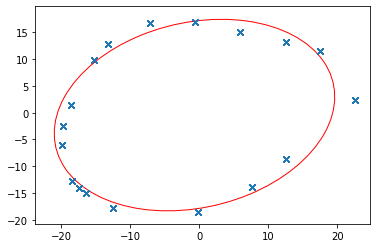

In [11]:
from matplotlib.patches import Ellipse

def aspect_ratio(df):
    """Returns the aspect ratio"""
    
    # Caculating the convex hull
    x,y = convex_hull(df)

    # Adding noise
    for i in range(0,len(x)):
        for j in range(0,20):
            x.append(x[i]+ random.uniform(0,0.001))
            y.append(y[i]+ random.uniform(0,0.001))
    
    points = np.array([x,y])
    points = points.transpose()

    # Calculating the ellipse
    ell = EllipseModel()
    ell.estimate(points)
    xc, yc, a, b, theta = ell.params

    if (a<b):
        return a/b,xc, yc, a, b, theta,x,y
    else:
        return b/a,xc, yc, a, b, theta,x,y
        
ar, xc, yc, a, b, theta,x,y = aspect_ratio(df)
ax = plt.gca()

print("aspect ratio =",ar)
plt.plot(x,y,"x")
ellipse = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')
ax.add_patch(ellipse)
plt.show()

## 2. Calculating the density

Here you will find the function to calculate the density from a simulation file or a converted experimental file.

The density of the colony can be calculated by using image analysis tool.
The principle is to calculate the number of pixels that represents the bacteria and the number of pixels of the filled colony. The density is then the ration betaween these two values.
<br> The density equal 1 if the bacteria occupy all the space of the colony.

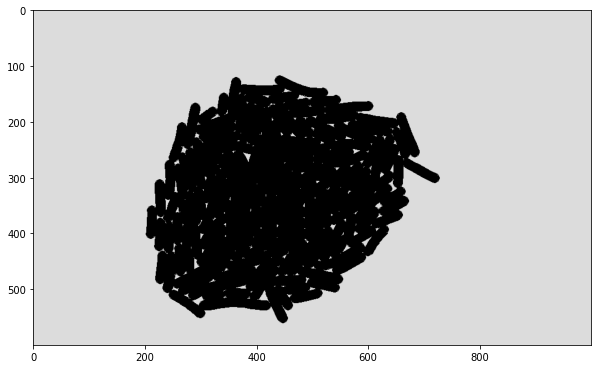

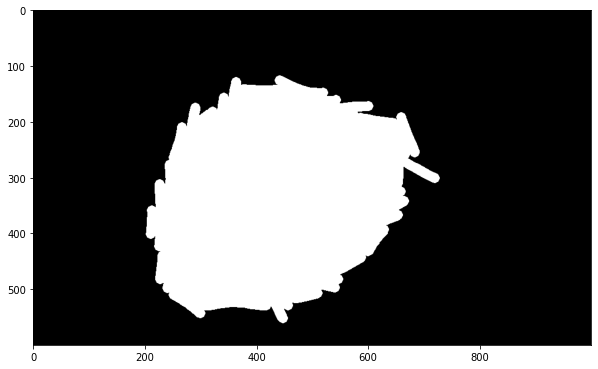

density= 0.9784101227454746


(0.9810249307479224, 1032.9375)

In [5]:
# Converting of array to binary
def gray_to_bin(im_array):
    """ Convert an image from greyscale to binary"""
    for i in range(im_array.shape[0]):
        for j in range(im_array.shape[1]):
            if im_array[i,j]!=1:
                im_array[i,j]=0

def density(file,time):
    """Returns the density of a colony for a certain time from a simulation file"""

    # Creating the grey and black image
    
    Pm = pm.Plot(file,time)
    graduation,convert = Pm.save(1)
    
    # Loading the image
    image_path = "temp" + ".png"

    # Inversing the colors
    Img_array2 = imread(image_path,as_gray=True)
    im =invert(Img_array2)
    gray_to_bin(im)
    
    # Calculating the number of pixels of the bacterias
    nb_color = np.sum(im)

    # Filling the holes
    filled = binary_fill_holes(im)
    
    # Calculating the area of the filled colony
    nb = np.sum(filled)

    os.remove("temp.png")
    
    return nb_color/nb,nb_color*(graduation/convert)**2 

### Density for experimental

def density_exp(file,time):
    """Returns the density of a colony for a certain time from a converted experimental file"""

    # Creating the grey and black image
    Pm = pmx.Plot(file,time)
    graduation,convert = Pm.save(1)

    # Loading the image
    image_path = "temp" + ".png"

    # Inversing the colors
    Img_array2 = imread(image_path,as_gray=True)
    im =invert(Img_array2)
    gray_to_bin(im)
    
    # Calculating the number of pixels of the bacterias
    nb_color = np.sum(im)

    # Filling the holes
    filled = binary_fill_holes(im)
    
    # Calculating the area of the filled colony
    nb = np.sum(filled)

    os.remove("temp.png")
    return nb_color/nb,nb_color*(graduation/convert)**2 

###############################################

# Creating the grey and black image
mm = pm.Plot("./simuc_data/"+file + ".txt")
mm.save(0)

# Loading and displaying the image
image_path = "./simuc_data/"+file + ".png"
Img_array = imread(image_path)
plt.figure(figsize=(10,8))
plt.imshow(Img_array)
plt.show()

shape = Img_array.shape

# Calculating the number of pixels of the bacterias
nb_color = 0
for i in range(shape[0]):
    for j in range(shape[1]):
        if identify_bact(Img_array[i,j,]):
            nb_color+=1

# Inversing the colors
Img_array = imread(image_path,as_gray=True)
im =invert(Img_array)

# Converting of array to binary
def gray_to_bin(im_array):
    """ Convert the image in greyscale to binary"""
    for i in range(im_array.shape[0]):
        for j in range(im_array.shape[1]):
            if im_array[i,j]!=1:
                im_array[i,j]=0

gray_to_bin(im)

# Filling the holes
filled = binary_fill_holes(im)
plt.figure(figsize=(10,8))
plt.imshow(filled,cmap=plt.cm.gray)
plt.show()

# Calculating the area of the filled colony
nb = 0
shape = filled.shape
for i in range(shape[0]):
    for j in range(shape[1]):
        if filled[i,j]==True:
            nb+=1

print("density=",nb_color/nb)
density("./method7/simu_data/simu1.txt",200) 
# density_exp("../Data_Duvernoy_converted/Coli/Coli1.txt",138)

## 3. The length quantifier

The function to calculate the length quantifier is implemented here.

The length quantifier quantifies the state of the hookean springs compared to their rest state.
<br>More $s$ is near to 0, more the springs are close to their equilibrum.

In [6]:
# Function to apply 
def qlength(X,l):
    """ Calculates the length quantifier """
    s = 0
    p_i = len(X)

    for i in range(0,p_i-3,2):
        s+= np.abs(norm(np.array([X[i+2],X[i+3]]) - np.array([X[i],X[i+1]]))-l)
    return s/(p_i-1)

def length_quantifier(df):
    """Returns the length quantifier s"""

    # Disks radius
    l = df["Disks radius"][0]
    # Calculating the mean for each bacterium
    mean_i = df["X"].apply(qlength,args=(l,))

    # Calculating the mean for all bacteria
    Ql = mean_i.mean()
    
    return Ql

print("Length quantifier = ",length_quantifier(df))


Length quantifier =  0.030660910494425587


## Energy Calculations

The following functions calculate the energy of the system for a certain dataframe.
We only use the Angular spring energy but the repulsion and linear energies can also be calculated.

The quantifier is the bending energy which characterize the bending of the bacteria of the colony.
More it is high more the bacteria are bent.

In [7]:
def CalcEnergyspring(bacteria : list[np.array],ks,kt_par,kt_bot,l):
    """  Calculate the energy of the system composed of the bacteria in argument"""
    El = 0
    Et = 0
    for i in range(0,len(bacteria)):
        p_i = bacteria[i].shape[0]
        X = bacteria[i]
        for j in range(0,p_i-1):
            # Energy of the linear springs
            El += 1/2*ks * ((norm(X[j+1] - X[j]) - l)**2/(l**2))
            if j>=1:    # Energy of the angular springs
                Et += 1/2*kt_par*(np.dot((X[j+1]-X[j]),(X[j-1] - X[j]))/(norm(X[j+1]-X[j])*norm(X[j-1] - X[j])+0.01) - np.cos(np.pi))**2
                Et += 1/2*kt_bot*(np.cross((X[j+1]-X[j]),(X[j-1] - X[j]))/(norm(X[j+1]-X[j])*norm(X[j-1] - X[j])+0.01) - np.sin(np.pi))**2
    return El,Et

def CalcEnergyrepulsion(bacteria : list[np.array],kc,l):
    """Calculate the energy of the interdisk repulsion"""
    E = 0

    for i in range(0,len(bacteria)):
        p_i = bacteria[i].shape[0]
        for j in range(0,p_i):
            Xj = bacteria[i][j]
            for h in range(0,len(bacteria)):
                if(h!=i):
                    p_h = bacteria[h].shape[0]
                    for k in range(0,p_h):
                        Xk = bacteria[h][k]
                        if(norm(Xj-Xk)) < 2*l:
                            E += 1/2*kc*((norm(Xj-Xk))/(2*l) -1)**2
    return E

## The  quantifiers as function of time

Calculating the quantifiers as functions of time and saving them as numpy files.
The files are saved in folders that needs to be created manully. Follows the examples in **./quantifiers_data** but in summary the file will be saved in the folder **./quantifiers_data/the_corresponding_quantifier/name_of_the_serie**.

In [8]:
# Quantifiers calculations for a serie simulation files
def quantifiers():
    """Calculates the quantifiers for a list of files"""

    # The files to load
    all_files = glob.glob("./method7/simu_data/*.txt")
    # all_files = glob.glob("./method7/simuc_data/*.txt")
    
    id = "simu22"

    for f in all_files:
        file = f[20:-4]     # For method7
        # file = f[10:-4]   # For method4
        if(file.split(sep="_")[0]==id):
            print(file)

            # Data loading and processing
            DF = pd.read_csv(f,sep="\t")
            DF["X"]=DF["X"].apply(convert)
            DF["time"] = DF["time"].apply(int)

            # Calculating the quantifiers
            times = DF["time"].drop_duplicates()
            n = times.shape[0]

            # quantifiers arrays
            ar = np.zeros(n)
            d = np.zeros(n)
            s = np.zeros(n)
            El = np.zeros(n)
            Et = np.zeros(n)
            N = np.zeros(n)

            # Stiffness parameters
            ks = DF["ks"][0]
            kt_par = DF["kt_par"][0]
            kt_bot = DF["kt_bot"][0]
            kc = DF["kc"][0]
            l = df["Disks radius"][0]

            k=0
            i=0

            # itering on the times
            for time in times :
                if(time <= 251):
                    # Selecting the data at the right time
                    cdf = DF.loc[DF["time"]==time]
                    cdf = cdf.reset_index()
                    
                    print(time)

                    ## Calculatung the quantifiers
                    ar[i],_,_,_,_,_,_,_ = aspect_ratio(cdf)
                    d[i] = density(f,time)
                    s[i] = length_quantifier(cdf)
                    i +=1
                    
                    # Converting the data into arrays
                    bacteria = []
                    for j in range(0,cdf.shape[0]):
                        X = cdf["X"][j]
                        temp = [ [X[h],X[h+1]] for h in range(0,len(X)-1,2) ]
                        bacteria.append(np.array(temp))
                    
                    # Calculating the energy
                    El[k],Et[k]=CalcEnergyspring(bacteria,ks,kt_par,kt_bot,l) 
                    El[k]/=cdf.shape[0]
                    Et[k]/=cdf.shape[0]
                    # Ec[k] = CalcEnergyrepulsion(bacteria,kc,l)
                    N[k]= cdf.shape[0]
                    k+=1

            # method 4
            # np.save("./quantifiers_data/aspect_ratio/"+ file.split("_")[0] + "/" + file + "_aspect_ratio.npy",ar)
            # np.save("./quantifiers_data/density/" + file.split("_")[0] + "/" + file + "_density.npy",d)
            # np.save("./quantifiers_data/length/" + file.split("_")[0] + "/" + file + "_length.npy",s)
            # np.save("./quantifiers_data/N/" + file.split("_")[0] + "/" + file + "_N.npy",N)

            # np.save("./quantifiers_data/energies/"+ file.split("_")[0] + "/El/" + file + "_El.npy",El)
            # np.save("./quantifiers_data/energies/"+ file.split("_")[0]+ "/Et/" + file + "_Et.npy",Et)
            # np.save("./quantifiers_data/energies/"+ file.split("_")[0] + "/Ec/"  + file + "_Ec.npy",Ec)

            # Method 7
            np.save("./method7/quantifiers/aspect_ratio/"+ file.split("_")[0] + "/" + file + "_aspect_ratio.npy",ar)
            np.save("./method7/quantifiers/density/" + file.split("_")[0] + "/" + file + "_density.npy",d)
            np.save("./method7/quantifiers/length/" + file.split("_")[0] + "/" + file + "_length.npy",s)
            np.save("./method7/quantifiers/N/" + file.split("_")[0] + "/" + file + "_N.npy",N)

            np.save("./method7/quantifiers/energies/"+ file.split("_")[0] + "/El/" + file + "_El.npy",El)
            np.save("./method7/quantifiers/energies/"+ file.split("_")[0]+ "/Et/" + file + "_Et.npy",Et)
            # np.save("./method7/quantifiers/energies/"+ file.split("_")[0] + "/Ec/"  + file + "_Ec.npy",Ec)

# Quantifiers calculation for the converted experimental data
def quantifiers_exp():
    """Calculates the quantifiers for a list of files"""

    # The files to load
    all_files = glob.glob("../Data_Duvernoy_converted/Coli/*.txt")
    
    for f in all_files[2:]:
        file = f[32:-4] 
        print(file)

        # Data loading and processing
        DF = pd.read_csv(f,sep="\t")
        DF["X"]=DF["X"].apply(convert)
        DF["time"] = DF["time"].apply(int)
        times = DF["time"].drop_duplicates()

        n = times.shape[0]

        # quantifiers arrays
        ar = np.zeros(n)
        d = np.zeros(n)
        N= np.zeros(n)
        T = []
        
        # Stiffness parameters
        ks = DF["ks"][0]
        kt_par = DF["kt_par"][0]
        kt_bot = DF["kt_bot"][0]
        kc = DF["kc"][0]
        l = df["Disks radius"][0]

        k=0
        i=0

        # Itering on the time
        for time in times :
            # Selecting the data at the rigth time
            cdf = DF.loc[DF["time"]==time]
            cdf = cdf.reset_index()
            
            print(time)

            # Calculating the quantifiers
            ar[i],_,_,_,_,_,_,_ = aspect_ratio(cdf)
            d[i] = density_exp(f,time)
            N[i] = cdf.shape[0]
            i +=1
            T.append(time)
            
            # Converting the data into arrays
            bacteria = []
            for j in range(0,cdf.shape[0]):
                X = cdf["X"][j]
                temp = [ [X[h],X[h+1]] for h in range(0,len(X)-1,2) ]
                bacteria.append(np.array(temp))
                
        np.save("../Data_Duvernoy_converted/quantifiers/N/" + file + "_N.npy",N)
        np.save("../Data_Duvernoy_converted/quantifiers/aspect_ratio/" + file + "_aspect_ratio.npy",ar)
        np.save("../Data_Duvernoy_converted/quantifiers/density/" + file +  "_density.npy",d)
        np.save("../Data_Duvernoy_converted/quantifiers/time/" + file +  "_time.npy",np.array(T))
    

# quantifiers()
# quantifiers_exp()



## The  quantifiers as function of the area

Calculating the quantifiers as functions of area and saving them as numpy files.
The files are saved in folders that needs to be created manully. Follows the examples in **./quantifiers_data_area** but in summary the file will be saved in the folder **./quantifiers_data_area/the_corresponding_quantifier/name_of_the_serie**..

In [10]:
def quantifiers_area():
    """ Calculates the quantifiers for a list of files as a function of the area """
    
    # Files to load
    # all_files = glob.glob("./method7/simu_data/*.txt")
    all_files = glob.glob("./simuc_data/*.txt")
    id = "simuc12"

    compteur = True

    # The intervals between the values
    order = 100

    # index to not exceed
    ia_max = 10000

    for f in all_files:
        # file = f[20:-4]   # Pour la méthode 7
        file = f[13:-4]     # Pour l'autre méthode
        # file = f[2:-4]    # A changer selon le chemin

        if(file.split(sep="_")[0]==id):
            print("----------->",file)
            
            # data loading
            DF = pd.read_csv(f,sep="\t")

            # Data processing
            DF["X"]=DF["X"].apply(convert)
            DF["time"] = DF["time"].apply(int)

            # Calculating the quantifiers
            times = DF["time"].drop_duplicates()

            # quantifiers arrays
            ar = []
            d = []
            s = []
            El = []
            Et = []
            N = []
            Area = []

            # for the area
            ia = 1

            # Stiffness parameters
            ks = DF["ks"][0]
            kt_par = DF["kt_par"][0]
            kt_bot = DF["kt_bot"][0]
            kc = DF["kc"][0]
            l = df["Disks radius"][0]

            for time in times :
                
                # Calculating the data at the right time
                cdf = DF.loc[DF["time"]==time]
                cdf = cdf.reset_index()

                print("time=",time)

                # Calculating the area
                dd,areaa = density(f,time)
                areaa = int(areaa)
                # print("area=",areaa)

                # checking if the area is sufficient according to the actual threshold
                if areaa>= ia*order and ia <= ia_max:
                    print("bonne area=",areaa)
                    print("th area",ia*order)

                    # Calculating the quantifiers
                    aspect_r,_,_,_,_,_,_,_ = aspect_ratio(cdf)
                    ar.append(aspect_r)
                    s.append(length_quantifier(cdf))
                    d.append(dd)

                    # Converting the data into arrays
                    bacteria = []
                    for j in range(0,cdf.shape[0]):
                        X = cdf["X"][j]
                        temp = [ [X[h],X[h+1]] for h in range(0,len(X)-1,2) ]
                        bacteria.append(np.array(temp))
                    
                    # Calculating the energy
                    Energies = CalcEnergyspring(bacteria,ks,kt_par,kt_bot,l) 
                    El.append(Energies[0]/cdf.shape[0])
                    Et.append(Energies[1]/cdf.shape[0])
                    N.append(cdf.shape[0])
                    Area.append(ia*order)
                    ia +=1

            # method 4
            print(ia)
            print(ia_max)
            if(ia==ia_max or compteur==True):
                np.save("./quantifiers_data_area/aspect_ratio/"+ file.split("_")[0] + "/" + file + "_aspect_ratio.npy",np.array(ar))
                np.save("./quantifiers_data_area/density/" + file.split("_")[0] + "/" + file + "_density.npy",np.array(d))
                np.save("./quantifiers_data_area/length/" + file.split("_")[0] + "/" + file + "_length.npy",np.array(s))
                np.save("./quantifiers_data_area/N/" + file.split("_")[0] + "/" + file + "_N.npy",np.array(N))
                np.save("./quantifiers_data_area/energies/"+ file.split("_")[0] + "/El/" + file + "_El.npy",np.array(El))
                np.save("./quantifiers_data_area/energies/"+ file.split("_")[0]+ "/Et/" + file + "_Et.npy",np.array(Et))
            
            # Saving the area only one time
            if compteur==True :
                np.save("./quantifiers_data_area/area/" + file.split("_")[0] + "/" + file + "_area.npy",np.array(Area))
                compteur = False
                ia_max = len(Area)+1
                print("ok")

            # Method 7
            # print(ia)
            # print(ia_max)
            # if(ia==ia_max or compteur==True):
            #     np.save("./method7/quantifiers_area/aspect_ratio/"+ file.split("_")[0] + "/" + file + "_aspect_ratio.npy",np.array(ar))
            #     np.save("./method7/quantifiers_area/density/" + file.split("_")[0] + "/" + file + "_density.npy",np.array(d))
            #     np.save("./method7/quantifiers_area/length/" + file.split("_")[0] + "/" + file + "_length.npy",np.array(s))
            #     np.save("./method7/quantifiers_area/N/" + file.split("_")[0] + "/" + file + "_N.npy",np.array(N))
            #     np.save("./method7/quantifiers_area/energies/"+ file.split("_")[0] + "/El/" + file + "_El.npy",np.array(El))
            #     np.save("./method7/quantifiers_area/energies/"+ file.split("_")[0]+ "/Et/" + file + "_Et.npy",np.array(Et))
            
            # if compteur==True :
            #     np.save("./method7/quantifiers_area/area/" + file.split("_")[0] + "/" + file + "_area.npy",np.array(Area))
            #     compteur = False
            #     ia_max = len(Area)+1
            #     print("ok")

def quantifiers_exp_area():
    """ Calculates the quantifiers for a list of files as a function of the area for the experimental data """
    
    # Files to load
    all_files = glob.glob("../Data_Duvernoy_converted/Coli/*.txt")

    compteur = True

    # The intervals between the values
    order = 100

    # index to not exceed
    ia_max = 10000

    for f in all_files:
        file = f[32:-4]
        print("----------->",file)

        # data loading
        DF = pd.read_csv(f,sep="\t")
        
        # Data processing
        DF["X"]=DF["X"].apply(convert)
        DF["time"] = DF["time"].apply(int)

        # Calculating the quantifiers
        times = DF["time"].drop_duplicates()

        # quantifiers arrays
        ar = []
        d = []
        N = []
        Area = []

        # for the area
        ia = 1

        # Stiffness parameters
        ks = DF["ks"][0]
        kt_par = DF["kt_par"][0]
        kt_bot = DF["kt_bot"][0]
        kc = DF["kc"][0]
        l = df["Disks radius"][0]

        for time in times :
            
            # Calculating the data at the right time
            cdf = DF.loc[DF["time"]==time]
            cdf = cdf.reset_index()

            # Calculating the area
            print("time=",time)
            dd,areaa = density_exp(f,time)
            areaa = int(areaa)
            # print("area=",areaa)

            if areaa>= ia*order and ia <= ia_max:
                print("bonne area=",areaa)
                print("th area",ia*order)
                # Calculating the quantifiers
                aspect_r,_,_,_,_,_,_,_ = aspect_ratio(cdf)
                ar.append(aspect_r)
                # s.append(length_quantifier(cdf))
                d.append(dd)
                N.append(cdf.shape[0])
                Area.append(ia*order)
                ia +=1

        np.save("../Data_Duvernoy_converted/quantifiers_area/N/" + file + "_N.npy",N)
        np.save("../Data_Duvernoy_converted/quantifiers_area/aspect_ratio/" + file + "_aspect_ratio.npy",ar)
        np.save("../Data_Duvernoy_converted/quantifiers_area/density/" + file +  "_density.npy",d)
        np.save("../Data_Duvernoy_converted/quantifiers_area/area/" + file + "_area.npy",np.array(Area))

# quantifiers_area()
# quantifiers_exp_area()